# Train and Visualize a PC on the Moons Dataset

In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda")  # The device to use, e.g., "cpu", "cuda", "cuda:1"

Set the random seeds.

In [3]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if 'cuda' in device.type:
    torch.cuda.manual_seed(42)

Generate the Dataset

In [4]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

data = make_moons(n_samples = 3000, noise=0.1, random_state=0)

X, y = data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) 

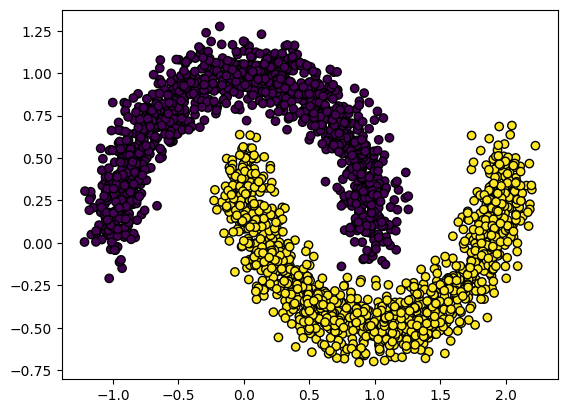

In [5]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="k")

## create the PC

In [6]:
import cirkit.new.region_graph as rg

region_graph = rg.algorithms.FullyFactorized(num_vars=2)

In [7]:
assert region_graph.is_smooth and region_graph.is_decomposable and region_graph.is_structured_decomposable and region_graph.is_omni_compatible
print(region_graph)

In [8]:
from cirkit.new.symbolic import (
    SymbolicTensorizedCircuit,
)
from cirkit.new.layers import (
    CPLayer,
    NormalLayer,
)
from cirkit.new.utils.type_aliases import ReparamFactory, SymbLayerCfg
from cirkit.new.reparams import EFNormalReparam, SoftmaxReparam


In [9]:
input_layer_cls = NormalLayer
input_reparam: ReparamFactory = EFNormalReparam

sum_layer_cls = CPLayer
sum_layer_kwargs = {}
sum_reparam = SoftmaxReparam

prod_layer_cls = CPLayer
prod_layer_kwargs = {}

symb_circuit = SymbolicTensorizedCircuit(region_graph,
                                         num_input_units=1024,
                                         num_sum_units=512,
                                         input_cfg=SymbLayerCfg(
                                            layer_cls=input_layer_cls,
                                            reparam_factory=input_reparam,
                                        ),
                                        sum_cfg=SymbLayerCfg(
                                            layer_cls=sum_layer_cls,
                                            layer_kwargs=sum_layer_kwargs, 
                                            reparam_factory=sum_reparam,
                                        ),
                                        prod_cfg=SymbLayerCfg(
                                            layer_cls=prod_layer_cls, 
                                            layer_kwargs=prod_layer_kwargs 
                                        ),
)

In [10]:
from cirkit.new.model.tensorized_circuit import TensorizedCircuit
tens_circuit = TensorizedCircuit(symb_circuit)

In [11]:
tens_circuit.to(device)
print(tens_circuit)

TensorizedCircuit(
  (layers): ModuleList(
    (0): NormalLayer(
      (params): EFNormalReparam(
        (reparams): ModuleList(
          (0): LeafReparam()
        )
      )
    )
    (1): DenseLayer(
      (params): SoftmaxReparam(
        (reparams): ModuleList(
          (0): LeafReparam()
        )
      )
    )
    (2): NormalLayer(
      (params): EFNormalReparam(
        (reparams): ModuleList(
          (0): LeafReparam()
        )
      )
    )
    (3): DenseLayer(
      (params): SoftmaxReparam(
        (reparams): ModuleList(
          (0): LeafReparam()
        )
      )
    )
    (4): CPLayer(
      (prod): HadamardLayer()
      (sum): DenseLayer(
        (params): SoftmaxReparam(
          (reparams): ModuleList(
            (0): LeafReparam()
          )
        )
      )
    )
  )
)


prepare the dataset for pytorch

In [12]:
from torch import optim
from torch.utils.data import DataLoader
train_dataloader = DataLoader(X_train, shuffle=True, batch_size=64)
test_dataloader = DataLoader(X_test, shuffle=False, batch_size=256)
#optimizer = optim.SGD(tens_circuit.parameters(), lr=0.5, momentum=0.9)
optimizer = optim.Adam(tens_circuit.parameters(), lr=0.05)

setting up the data for the plots

In [13]:
x1_bounds = (-1.5,2.5)
x2_bounds = (-1,1.5)
num_samples = 400
x2 = np.linspace(0, 1, num_samples)*(x2_bounds[1] - x2_bounds[0]) + x2_bounds[0]
x1 = np.linspace(0, 1, num_samples)*(x1_bounds[1] - x1_bounds[0]) + x1_bounds[0]
x1v, x2v = np.meshgrid(x1, x2)
X_meshgrid_np = np.stack((x1v,x2v), axis=-1).reshape(-1,2)
X_meshgrid_np.shape
X_meshgrid = torch.from_numpy(X_meshgrid_np).float()

In [14]:
X_meshgrid.min(0).values, X_meshgrid.max(0).values

(tensor([-1.5000, -1.0000]), tensor([2.5000, 1.5000]))

In [15]:
from matplotlib.pyplot import xlim, ylim

def print_density(title=None, scatter=False):
    log_score = tens_circuit(X_meshgrid.to(device).float().unsqueeze(dim=-1))
    log_score = log_score.reshape(num_samples,num_samples)
    plt.imshow(log_score.cpu().detach().numpy(), extent=(*x1_bounds, *x2_bounds), origin="lower")
    if title is not None:
        plt.title(title)
    if scatter:
        plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5)
    plt.show()

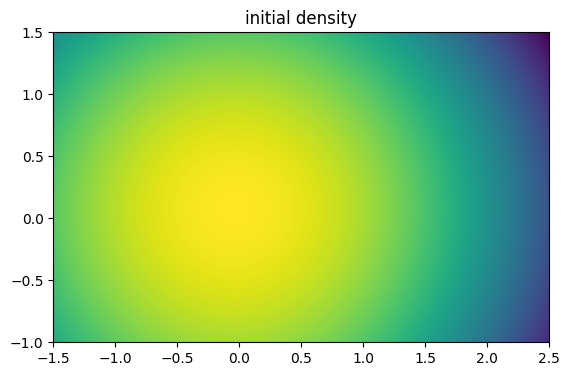

In [16]:
print_density("initial density")

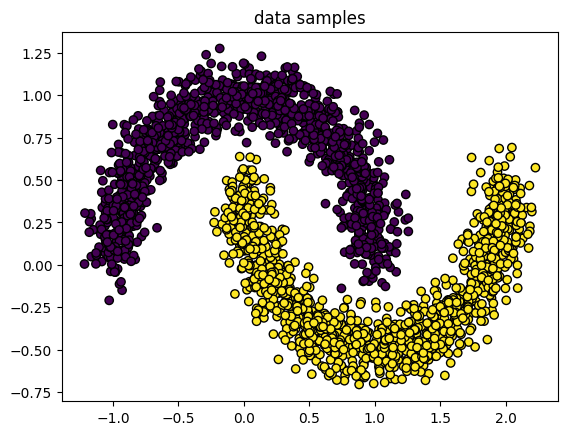

In [17]:
plt.title("data samples")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="k")
plt.show()

In [18]:
losses = []

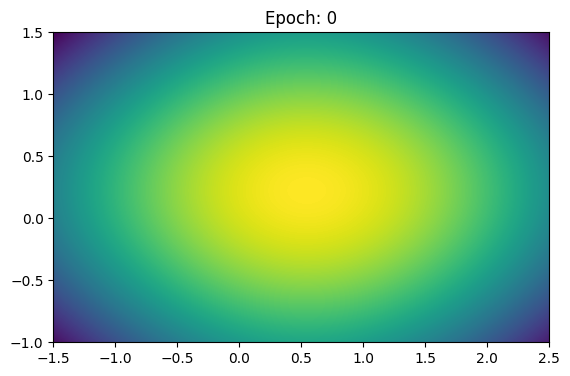

Epoch 0: Average NLL: 2.759
Epoch 5: Average NLL: 1.327
Epoch 10: Average NLL: 1.129
Epoch 15: Average NLL: 1.130
Epoch 20: Average NLL: 1.121
Epoch 25: Average NLL: 1.131
Epoch 30: Average NLL: 1.114
Epoch 35: Average NLL: 1.106
Epoch 40: Average NLL: 1.121
Epoch 45: Average NLL: 1.120


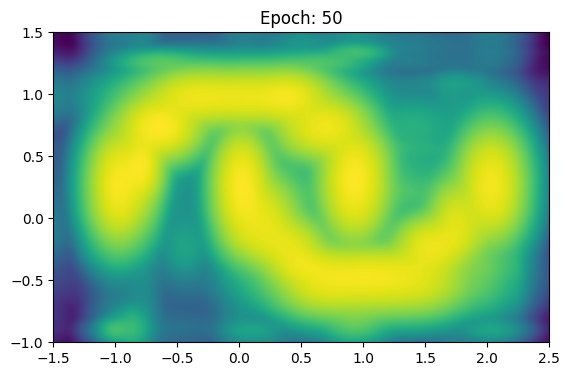

Epoch 50: Average NLL: 1.104
Epoch 55: Average NLL: 1.106
Epoch 60: Average NLL: 1.109
Epoch 65: Average NLL: 1.107
Epoch 70: Average NLL: 1.110
Epoch 75: Average NLL: 1.109
Epoch 80: Average NLL: 1.102
Epoch 85: Average NLL: 1.096
Epoch 90: Average NLL: 1.115
Epoch 95: Average NLL: 1.112


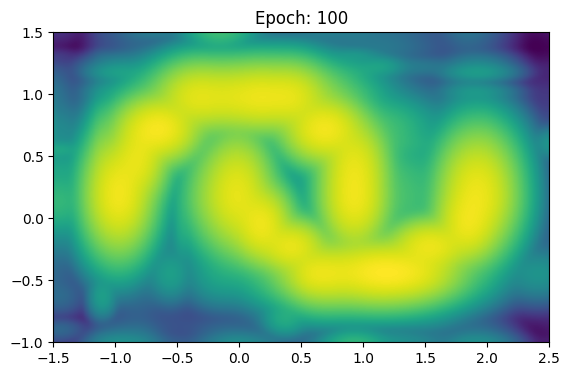

Epoch 100: Average NLL: 1.123
Epoch 105: Average NLL: 1.096
Epoch 110: Average NLL: 1.118
Epoch 115: Average NLL: 1.110
Epoch 120: Average NLL: 1.112
Epoch 125: Average NLL: 1.107
Epoch 130: Average NLL: 1.102
Epoch 135: Average NLL: 1.127
Epoch 140: Average NLL: 1.094
Epoch 145: Average NLL: 1.097


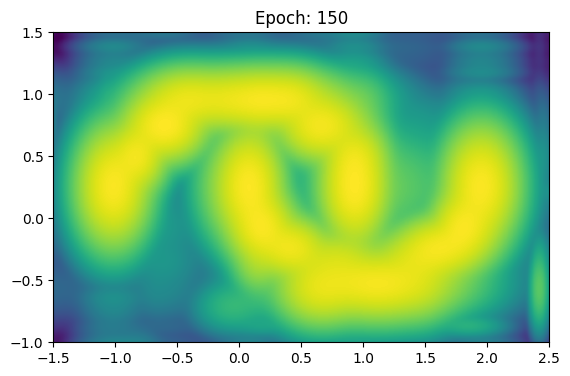

Epoch 150: Average NLL: 1.116
Epoch 155: Average NLL: 1.083
Epoch 160: Average NLL: 1.110
Epoch 165: Average NLL: 1.113
Epoch 170: Average NLL: 1.097
Epoch 175: Average NLL: 1.087
Epoch 180: Average NLL: 1.093
Epoch 185: Average NLL: 1.113
Epoch 190: Average NLL: 1.112
Epoch 195: Average NLL: 1.113


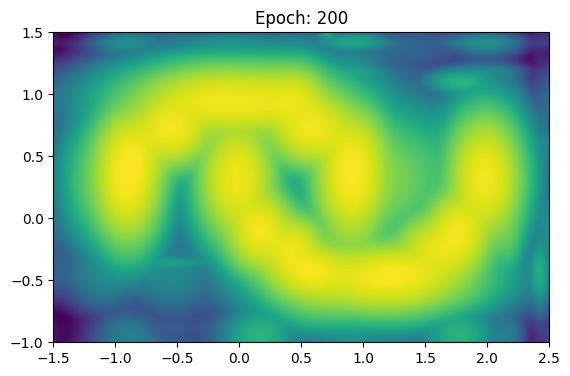

Epoch 200: Average NLL: 1.094
Epoch 205: Average NLL: 1.099
Epoch 210: Average NLL: 1.104
Epoch 215: Average NLL: 1.102
Epoch 220: Average NLL: 1.099
Epoch 225: Average NLL: 1.107
Epoch 230: Average NLL: 1.101
Epoch 235: Average NLL: 1.088
Epoch 240: Average NLL: 1.091
Epoch 245: Average NLL: 1.115


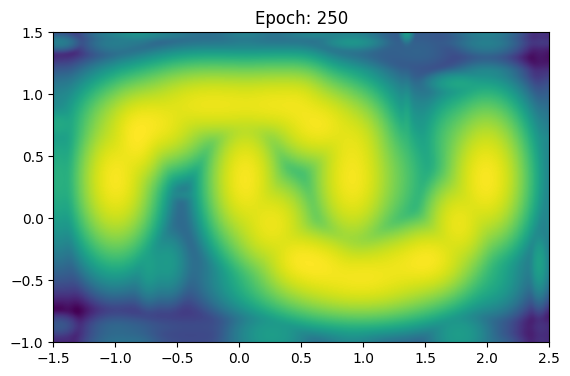

Epoch 250: Average NLL: 1.101
Epoch 255: Average NLL: 1.102
Epoch 260: Average NLL: 1.098
Epoch 265: Average NLL: 1.103
Epoch 270: Average NLL: 1.112
Epoch 275: Average NLL: 1.098
Epoch 280: Average NLL: 1.096
Epoch 285: Average NLL: 1.095
Epoch 290: Average NLL: 1.094
Epoch 295: Average NLL: 1.082


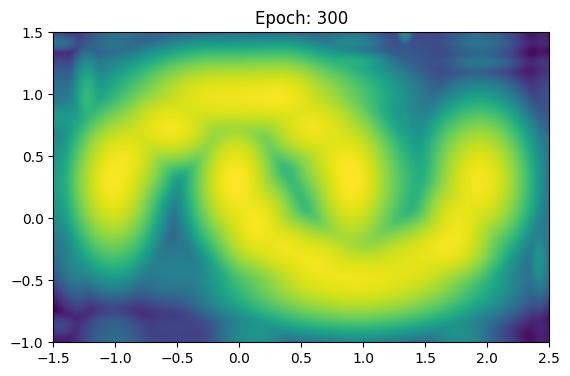

Epoch 300: Average NLL: 1.097
Epoch 305: Average NLL: 1.109
Epoch 310: Average NLL: 1.077
Epoch 315: Average NLL: 1.097
Epoch 320: Average NLL: 1.101
Epoch 325: Average NLL: 1.103
Epoch 330: Average NLL: 1.084
Epoch 335: Average NLL: 1.096
Epoch 340: Average NLL: 1.109
Epoch 345: Average NLL: 1.092


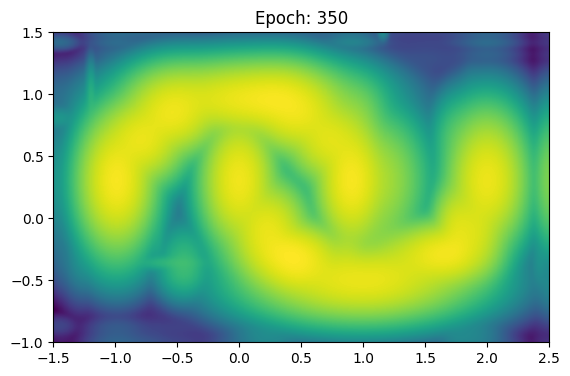

Epoch 350: Average NLL: 1.109
Epoch 355: Average NLL: 1.085
Epoch 360: Average NLL: 1.084
Epoch 365: Average NLL: 1.110
Epoch 370: Average NLL: 1.090
Epoch 375: Average NLL: 1.099
Epoch 380: Average NLL: 1.092
Epoch 385: Average NLL: 1.073
Epoch 390: Average NLL: 1.101
Epoch 395: Average NLL: 1.111


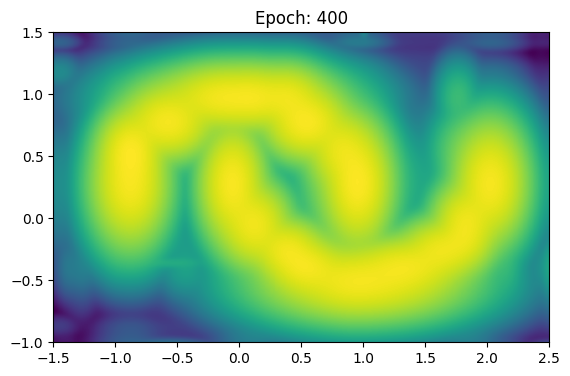

Epoch 400: Average NLL: 1.096
Epoch 405: Average NLL: 1.102
Epoch 410: Average NLL: 1.135
Epoch 415: Average NLL: 1.095
Epoch 420: Average NLL: 1.087
Epoch 425: Average NLL: 1.081
Epoch 430: Average NLL: 1.091
Epoch 435: Average NLL: 1.085
Epoch 440: Average NLL: 1.104
Epoch 445: Average NLL: 1.098


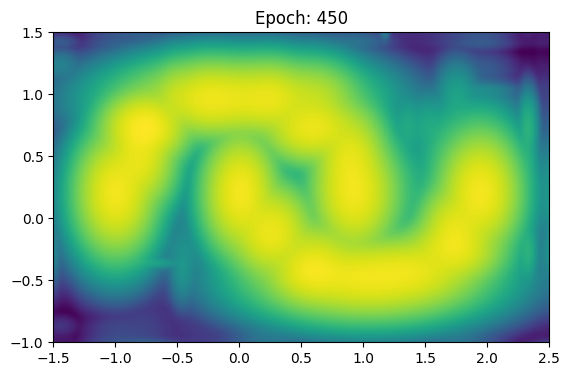

Epoch 450: Average NLL: 1.091
Epoch 455: Average NLL: 1.115
Epoch 460: Average NLL: 1.090
Epoch 465: Average NLL: 1.081
Epoch 470: Average NLL: 1.104
Epoch 475: Average NLL: 1.090
Epoch 480: Average NLL: 1.098
Epoch 485: Average NLL: 1.104
Epoch 490: Average NLL: 1.098
Epoch 495: Average NLL: 1.096


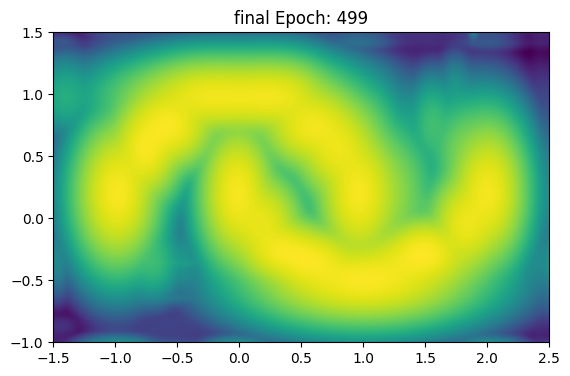

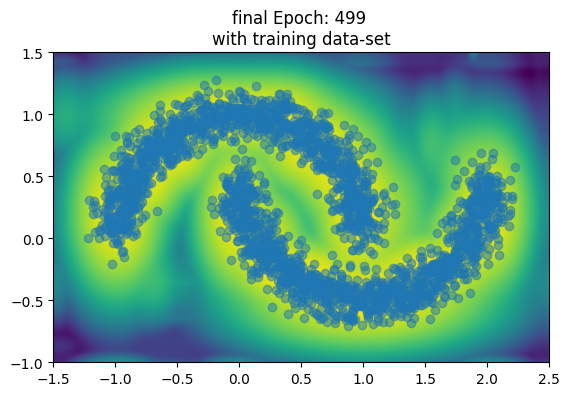

In [19]:
num_epochs = 500
for epoch_idx in range(num_epochs):
    running_loss = 0.0
    for batch in train_dataloader:
        batch = batch.to(device).float().unsqueeze(dim=-1)  # Add a channel dimension
        log_score = tens_circuit(batch)
        lls = log_score
        loss = -torch.mean(lls)   # The loss is the negative average log-likelihood
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss * len(batch)

    losses.append((running_loss / len(X_train)).cpu().detach().numpy())
    if epoch_idx % (num_epochs // 10) == 0:
        print_density(f"Epoch: {epoch_idx}")
    if epoch_idx % (num_epochs // 100) == 0:
        print(f"Epoch {epoch_idx}: Average NLL: {running_loss / len(X_train):.3f}")
print_density(f"final Epoch: {epoch_idx}", scatter=False)
print_density(f"final Epoch: {epoch_idx} \nwith training data-set", scatter=True)

test hold-out average log-likelihood

In [20]:
test_running_loss = 0.0
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device).float().unsqueeze(dim=-1)  # Add a channel dimension
        log_score = tens_circuit(batch)
        lls = log_score
        loss = -torch.mean(lls)   # The loss is the negative average log-likelihood
        test_running_loss += loss * len(batch)
train_running_loss = 0.0
with torch.no_grad():
    for batch in train_dataloader:
        batch = batch.to(device).float().unsqueeze(dim=-1)  # Add a channel dimension
        log_score = tens_circuit(batch)
        lls = log_score
        loss = -torch.mean(lls)   # The loss is the negative average log-likelihood
        train_running_loss += loss * len(batch)
print(f"hold-out avg log-like.: {test_running_loss/len(X_test):.2f} vs train: {train_running_loss/len(X_train):.2f}")

hold-out avg log-like.: 1.06 vs train: 1.08


A 3d-plot better visualizes our resulting density

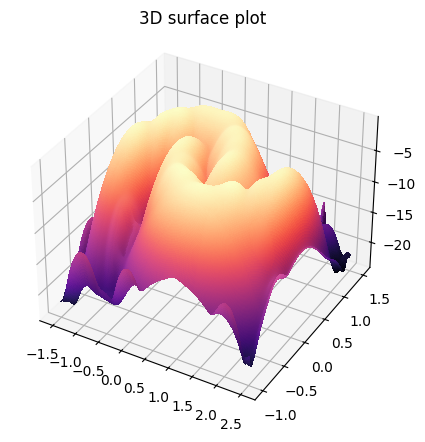

In [21]:
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
from matplotlib import colormaps


log_score = tens_circuit(X_meshgrid.to(device).float().unsqueeze(dim=-1)).detach().cpu()
log_score = log_score.reshape(num_samples,num_samples).numpy()
nrows, ncols = log_score.shape

# Set up plot
fig, ax = plt.subplots(figsize=(15,5), subplot_kw=dict(projection='3d'))
ax.set_title("3D surface plot")
ls = LightSource(270, 25)

# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(log_score, cmap=colormaps["magma"], vert_exag=1.0, blend_mode='soft')
ax.view_init(elev=35.)
surf = ax.plot_surface(x1v, x2v, log_score, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

our log-likelihood over iterations

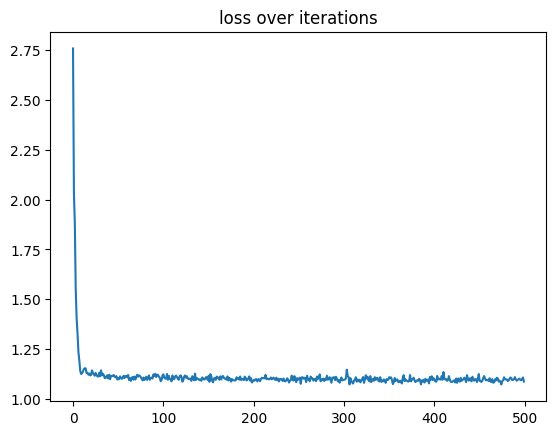

In [22]:
plt.title("loss over iterations")
plt.plot(losses)
plt.show()

our circuit is normalized by construction, which we can verify like this:

In [23]:
from cirkit.new.model.functional import integrate
pc_pf = integrate(tens_circuit)

In [26]:
log_pf = pc_pf(batch)
assert torch.allclose(log_pf, torch.tensor(0.), atol=1e-6)